In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.5)
sns.set_style("darkgrid", {'axes.grid' : False})   

%matplotlib inline

In [3]:
drive_path = '/Volumes/Brain2016/'

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

In [5]:
def open_h5_file(session_id, drive_path, letter='B', stim_abbrev='ns'):
#     session_id, session_data = get_session_id(exp_container_id, letter)
    path = drive_path + '/BrainObservatory/ophys_analysis/' + str(session_id) + '_three_session_'+letter+'_analysis.h5'
    f = h5py.File(path, 'r')
    response = f['analysis']['response_'+stim_abbrev].value
    f.close()
    mean_sweep_response=pd.read_hdf(path, 'analysis/mean_sweep_response_'+stim_abbrev)
    sweep_response = pd.read_hdf(path, 'analysis/sweep_response_'+stim_abbrev)
    peak = pd.read_hdf(path, 'analysis/peak')
    return response, mean_sweep_response, sweep_response, peak


### get experiment containers meeting certain criteria

In [6]:
#get experiment_containers meeting certain criteria
expts = boc.get_ophys_experiments(targeted_structures=['VISal'],cre_lines=['Cux2-CreERT2'],
                                  imaging_depths=[275],session_types=['three_session_B'])
expts = pd.DataFrame(expts)
print len(expts),'experiments meet these criteria'
expts.head()

4 experiments meet these criteria


,age_days,cre_line,experiment_container_id,id,imaging_depth,session_type,targeted_structure
0,95.0,Cux2-CreERT2,511854338,512149367,275,three_session_B,VISal
1,111.0,Cux2-CreERT2,511510867,504625475,275,three_session_B,VISal
2,111.0,Cux2-CreERT2,511511052,507691380,275,three_session_B,VISal
3,101.0,Cux2-CreERT2,511856567,511976329,275,three_session_B,VISal


In [7]:
#get experiment session id for the first experiment container
session_id = expts.id.values[0]
print session_id

512149367


### get NS stuff from processed data files

In [8]:
response, mean_sweep_response, sweep_response, peak = open_h5_file(session_id, drive_path, letter='B', stim_abbrev='ns')

In [9]:
peak.keys()

Index([u'speed_max_sp', u'speed_min_sp', u'ptest_sp', u'mod_sp',
       u'speed_max_vis', u'speed_min_vis', u'ptest_vis', u'mod_vis', u'ori_sg',
       u'sf_sg', u'phase_sg', u'response_variability_sg', u'osi_sg',
       u'peak_dff_sg', u'ptest_sg', u'time_to_peak_sg', u'duration_sg',
       u'scene_ns', u'response_variability_ns', u'peak_dff_ns', u'ptest_ns',
       u'p_run_ns', u'run_modulation_ns', u'time_to_peak_ns', u'duration_ns',
       u'peak_nm1', u'response_variability_nm1', u'ophys_experiment_id',
       u'area', u'targeted_structure', u'imaging_depth', u'depth',
       u'experiment_container_id', u'experiment_id', u'device', u'cre_line'],
      dtype='object')

### get data_set for this experiment session

In [10]:
#get data for a single experiment session
data_set = boc.get_ophys_experiment_data(ophys_experiment_id = session_id)

In [11]:
#get stimulus template (aka stimulus frames) for images, movies or locally sparse noise
images = data_set.get_stimulus_template(stimulus_name='natural_scenes')
images.shape

(118, 918, 1174)

In [12]:
#get stimulus table
stim_table = data_set.get_stimulus_table('natural_scenes')
stim_table.head()

,frame,start,end
0,117,16098,16105
1,22,16106,16113
2,99,16113,16120
3,76,16121,16128
4,89,16128,16135


### stimulus specific analysis - natural_scenes

In [13]:
# #stimulus specific analysis
# from allensdk.brain_observatory.natural_scenes import NaturalScenes
# ns = NaturalScenes(data_set)

In [14]:
#mean response for all image conditions for cell 
cell = 0
mean_image_responses = response[:,cell,0] #[image,cell,mean]

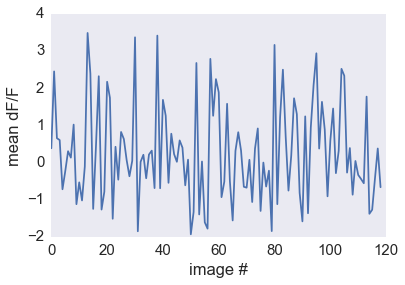

In [15]:
plt.plot(mean_image_responses)
plt.xlabel('image #')
plt.ylabel('mean dF/F')

### find pref image & plot mean response to that image

In [17]:
cell_ids = data_set.get_cell_specimen_ids()

In [18]:
#if the mean of the mean response to the preferred condition is > 5%
responsive_cell_idxs = peak[peak.peak_dff_ns>=5].index.values
responsive_cells = np.asarray([cell_ids[x] for x in responsive_cell_idxs])
len(responsive_cells)

63

In [19]:
cell_specimen_id = responsive_cells[0]

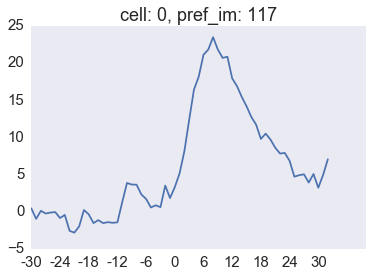

In [20]:
# cell_specimen_id = data_set.get_cell_specimen_ids()[cell_id]
cell_idx = np.where(cell_ids==cell_specimen_id)[0][0]
pref_scene = peak.iloc[cell_idx].scene_ns
pref_scene_sweeps = stim_table[stim_table.frame==pref_scene].index.values

condition_mean = sweep_response[str(cell_idx)].iloc[pref_scene_sweeps].mean()
frames = 63
t = np.arange(0,frames)
t_int = np.arange(0,frames,6)
t_int_ref = t_int - 30

fig,ax = plt.subplots()
ax.plot(t,condition_mean)
ax.set_xticks(t_int);
ax.set_xticklabels(t_int_ref);
# ax.set_xlabel('time after stimulus onset')
# ax.set_ylabel('dF/F')
ax.set_title('cell: '+str(cell)+', pref_im: '+str(pref_scene))

### make it a function

In [21]:
def plot_pref_condition_response(cell_specimen_id,images,sweep_response,peak,cell_ids):
    cell_idx = np.where(cell_ids==cell_specimen_id)[0][0]
    pref_scene = peak.iloc[cell_idx].scene_ns
    pref_scene_sweeps = stim_table[stim_table.frame==pref_scene].index.values

    condition_mean = sweep_response[str(cell_idx)].iloc[pref_scene_sweeps].mean()
    frames = 63
    t = np.arange(0,frames)
    t_int = np.arange(0,frames,6)
    t_int_ref = t_int - 30

    fig,ax = plt.subplots(1,2,figsize=(12,4))
    ax = ax.ravel()
    ax[0].plot(condition_mean)
    ax[0].set_xticks(t_int);
    ax[0].set_xlim([np.min(t_int),np.max(t_int)])
    ax[0].set_xticklabels(t_int_ref/30.);
    ax[0].set_xlabel('time after stimulus onset')
    ax[0].set_ylabel('dF/F')
    ax[0].set_title('cell: '+str(cell))
    
    ax[1].imshow(images[pref_scene,:,:],cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('pref image: '+str(pref_scene))

In [ ]:
condition_mean.shape

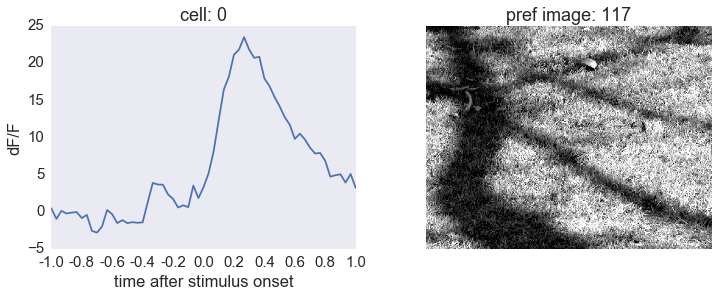

In [22]:
plot_pref_condition_response(cell_specimen_id,images,sweep_response,peak,cell_ids)

### find frames where response was greater than threshold dF/F value and determine which images were shown during those frames, then create response triggered average image, weighted by stength of response during those frames

In [23]:
#for a given cell in the list of responsive cells computed above
responsive_cell_idx = 1
cell_specimen_id = responsive_cells[responsive_cell_idx]
cell_idx = np.where(cell_ids==cell_specimen_id)[0][0]

In [24]:
#get traces for all responsive cells (not all cells in experiment_session)
timestamps,traces = data_set.get_dff_traces(cell_specimen_ids=responsive_cells)

In [25]:
#create array containing just the imaging frames when natural images were shown (frames_arr), 
#and and array of the natural images that were shown for those frames (images_arr)
frames_arr = np.empty(0)
images_arr = np.empty(0)
for sweep in range(len(stim_table)):
    start = stim_table.iloc[sweep].start
    end = stim_table.iloc[sweep].end
    frames = np.arange(start,end+1)
#     print frames.shape
    frames_arr = np.hstack((frames_arr,frames))
    image = stim_table.iloc[sweep].frame
    for i in range(len(frames)):
        images_arr = np.hstack((images_arr,image))

In [26]:
#for all responsive cells, get the dF/F values for frames where natural images were shown
traces_arr = np.empty((traces.shape[0],frames_arr.shape[0]))
for t in range(traces.shape[0]): 
    trace = np.empty(0)
    for sweep in range(len(stim_table)):
        start = stim_table.iloc[sweep].start
        end = stim_table.iloc[sweep].end
        tmp = traces[t,start:end+1]
        trace = np.hstack((trace,tmp))
    traces_arr[t,:] = trace

In [27]:
#get indices where trace response was > threshold dF/F
thresh_inds = np.where(traces_arr[responsive_cell_id,:]>=0.5)[0]
thresh_inds = thresh_inds - 6 #want to look at image present 6 frames prior to response 

In [28]:
#get dF/F values for frames with response > threshold
thresh_vals = traces_arr[responsive_cell_id][thresh_inds]

In [29]:
#get images that were shown on frames where response > threshold
thresh_images = images_arr[thresh_inds]

In [30]:
#create stack of images that were present when response > threshold
img_stack = np.empty((thresh_images.shape[0],images[0,:,:].shape[0],images[0,:,:].shape[1]))
for i,img in enumerate(thresh_images):
    img_stack[i,:,:] = images[img,:,:]

/Users/marinag/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


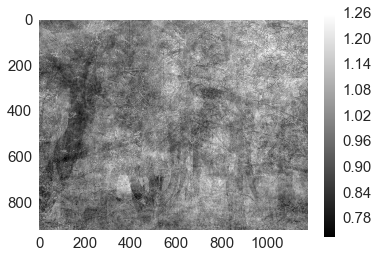

In [31]:
#plot mean of all images that were present prior to cell response, normalized to the mean across all images
mean_image = np.mean(img_stack,axis=0)
all_images_mean = np.mean(images,axis=0)
plt.imshow(mean_image/all_images_mean,cmap='gray')
plt.colorbar()

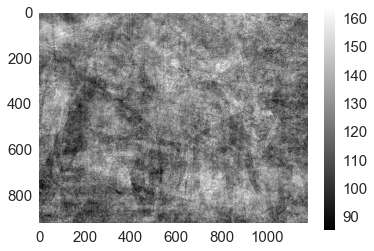

In [32]:
#plot mean image weighted by response magnitude 
weighted_mean_image = np.average(img_stack,axis=0,weights=thresh_vals)
plt.imshow(weighted_mean_image,cmap='gray')
plt.colorbar()

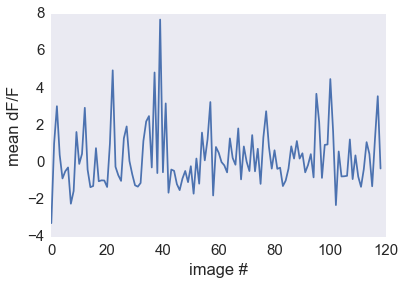

In [33]:
#plot mean response to all images
mean_image_responses = response[:,cell_idx,0] #[image,cell,mean]
plt.plot(mean_image_responses)
plt.xlabel('image #')
plt.ylabel('mean dF/F')

### create functions to get all responsive frames and average the images that were shown prior to those frames

In [34]:
def plot_trace(traces,responsive_cell_idx,cell_specimen_id,thresh,save_dir=None):
    fig,ax = plt.subplots(figsize=(15,5))
    trace = traces[responsive_cell_idx]
    ax.plot(trace)
    ax.set_title('cell '+str(cell_specimen_id))
    ax.set_xlim([0,len(trace)])
    ax.hlines(y=thresh, xmin=0, xmax=len(trace),color='g')
    if save_dir: 
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_path = os.path.join(save_dir,str(cell_specimen_id)+'_trace.png')
        fig.savefig(save_path)

In [35]:
#processing on all traces
def get_ns_response_arrays(data_set):
    timestamps,traces = data_set.get_dff_traces(cell_specimen_ids=responsive_cells)

    frames_arr = np.empty(0)
    images_arr = np.empty(0)
    for sweep in range(len(stim_table)):
        start = stim_table.iloc[sweep].start
        end = stim_table.iloc[sweep].end
        frames = np.arange(start,end)
        frames_arr = np.hstack((frames_arr,frames))
        image = stim_table.iloc[sweep].frame
        for i in range(len(frames)):
            images_arr = np.hstack((images_arr,image))

    traces_arr = np.empty((traces.shape[0],frames_arr.shape[0]))
    for t in range(traces.shape[0]): 
        trace = np.empty(0)
        for sweep in range(len(stim_table)):
            start = stim_table.iloc[sweep].start
            end = stim_table.iloc[sweep].end
            tmp = traces[t,start:end]
            trace = np.hstack((trace,tmp))
        traces_arr[t,:] = trace

    return frames_arr, images_arr, traces_arr     

In [36]:
def plot_ns_summary(cell_specimen_id,responsive_cell_idx,data_set,peak,sweep_response,images,arr,thresh=0.5,weighted=False,save_dir=False): 
    frames_arr = arr[0]
    images_arr = arr[1]
    traces_arr = arr[2]
    stim_table = data_set.get_stimulus_table('natural_scenes')
    cell_ids = data_set.get_cell_specimen_ids()
    
    cell_idx = np.where(cell_ids==cell_specimen_id)[0][0]
    pref_scene = peak.iloc[cell_idx].scene_ns
    pref_scene_sweeps = stim_table[stim_table.frame==pref_scene].index.values

    condition_mean = sweep_response[str(cell_idx)].iloc[pref_scene_sweeps].mean()
    condition_sem = np.std(sweep_response[str(cell_idx)].iloc[pref_scene_sweeps].values)/float(len(pref_scene_sweeps))
    frames = 63
    t = np.arange(0,frames)
    t_int = np.arange(0,frames,6)
    t_int_ref = t_int - 30

    thresh_inds = np.where(traces_arr[responsive_cell_idx,:]>=thresh)[0]
    thresh_inds = thresh_inds - 6
    thresh_vals = traces_arr[responsive_cell_idx][thresh_inds]
    thresh_images = images_arr[thresh_inds]
    n_images = len(np.unique(thresh_images))
    img_stack = np.empty((thresh_images.shape[0],images[0,:,:].shape[0],images[0,:,:].shape[1]))
    for i,img in enumerate(thresh_images):
        img_stack[i,:,:] = images[img,:,:]
    if weighted: 
        mean_image = np.average(img_stack,axis=0,weights=thresh_vals)/np.mean(images,axis=0)
    else: 
        mean_image = np.mean(img_stack,axis=0)/np.mean(images,axis=0)

    condition_response = response
    mean_image_responses = condition_response[:,cell_idx,0] #[image,cell,mean]
    sem_image_responses = condition_response[:,cell_idx,1] #[image,cell,mean]
    
    fig,ax = plt.subplots(2,2,figsize=(15,10))
    ax = ax.ravel()
    ax[0].plot(t,condition_mean)
    x = condition_mean
    y1 = condition_mean+condition_sem
    y2 = condition_mean-condition_sem
    ax[0].fill_between(x=np.arange(0,len(x)),y1=y1,y2=y2,alpha=0.5)
    ax[0].set_xticks(t_int);
    ax[0].set_xticklabels(t_int_ref/30.);
    ax[0].set_xlabel('time after stimulus onset')
    ax[0].set_ylabel('dF/F')
    ax[0].set_title('mean response to preferred condition')

    ax[1].imshow(images[pref_scene,:,:],cmap='gray')
    ax[1].set_title('preferred image: '+str(pref_scene))
    ax[1].axis('off')

    ax[2].plot(mean_image_responses,color='green')
    x = mean_image_responses
    y1 = mean_image_responses+sem_image_responses
    y2 = mean_image_responses-sem_image_responses
    ax[2].fill_between(x=np.arange(0,len(x)),y1=y1,y2=y2,alpha=0.5,color='green')
    ax[2].set_xlabel('image #')
    ax[2].set_ylabel('mean dF/F')
    ax[2].set_title('mean response across image conditions')

    ax[3].imshow(mean_image,cmap='gray')
    ax[3].axis('off')
    if weighted:
        ax[3].set_title('weighted mean of '+str(n_images)+' image conditions')
    else:
        ax[3].set_title('mean of '+str(n_images)+' image conditions')
    plt.tight_layout()
    if save_dir: 
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_path = os.path.join(save_dir,str(cell_specimen_id)+'.png')
        fig.savefig(save_path)
    # ax[4:5].plot(traces[cell_idx,:])

In [37]:
def get_folder_name(data_set): 
    metadata = data_set.get_metadata()
    area = metadata['targeted_structure']
    expt_id = metadata['ophys_experiment_id']
    cre_line = metadata['genotype'].split(';')[0]
    depth = metadata['imaging_depth_um']
    folder_name = str(expt_id)+'_'+area+'_'+cre_line+'_'+str(depth)
    return folder_name

In [ ]:
arr = get_ns_response_arrays(data_set)

In [ ]:
responsive_cell_id = 2
cell_specimen_id = responsive_cells[responsive_cell_id]
thresh = 0.3
folder_name = get_folder_name(data_set)
save_dir = os.path.join(r'/Users/marinag/Data/BrainObservatory/natural_scenes_plots/',folder_name)
plot_ns_summary(cell_specimen_id,responsive_cell_id,data_set,peak,sweep_response,images,arr,thresh,weighted=True,save_dir=save_dir)
plot_trace(traces,responsive_cell_id,cell_specimen_id,thresh,save_dir=None)


In [ ]:
#plot for all responsive cells in this experiment_session
thresh = 0.5
folder_name = get_folder_name(data_set)
save_dir = os.path.join(r'/Users/marinag/Data/BrainObservatory/natural_scenes_plots/',folder_name)
for responsive_cell_id, cell_specimen_id in enumerate(responsive_cells):
    print responsive_cell_id,cell_specimen_id
    plot_ns_summary(cell_specimen_id,responsive_cell_id,data_set,peak,sweep_response,images,arr,thresh,weighted=True,save_dir=save_dir)
    plot_trace(traces,responsive_cell_id,cell_specimen_id,thresh,save_dir=None)

### plot for all responsive cells & save 

In [ ]:
# #plot for all responsive cells in this experiment_session
# save_dir = os.path.join(r'/Users/marinag/Data/BrainObservatory/natural_scenes_plots/',str(session_id))
# for responsive_cell_id, cell_specimen_id in enumerate(responsive_cells):
#     plot_ns_summary(cell_specimen_id,responsive_cell_id,ns,images,frames_arr,images_arr,traces_arr,thresh=0.5,weighted=True,save_dir=save_dir)

### compare population response in natural scenes to drifting gratings

In [ ]:
# #stimulus specific analysis
# from allensdk.brain_observatory.static_gratings import StaticGratings
# sg = StaticGratings(data_set)

In [ ]:
# help(sg)

In [ ]:
# sg_response = np.empty(((6*6*4),sg.response.shape[3]))
# cond = 0 
# for i in range((sg.response.shape[0])):
#     for x in range((sg.response.shape[1])):
#         for y in range((sg.response.shape[2])):
# #             print 'ori:',sg.orivals[i],'sf:',sg.sfvals[x],'phase:',sg.phasevals[y]
#             sg_response[cond,:] = sg.response[i,x,y,:,0]
#             cond +=1

In [ ]:
# fix,ax=plt.subplots(figsize=(15,10))
# ax.pcolormesh(sg_response[:,:],cmap='jet',vmin=0,vmax=20)
# ax.set_title('population response to static gratings')

In [ ]:
fix,ax=plt.subplots(figsize=(15,10))
ax.pcolormesh(ns.response[:,:,0],cmap='jet',vmin=0,vmax=20)
ax.set_title('population repsonse to natural scenes')